In [34]:
%load_ext autoreload
%autoreload 2

from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from obspy import read, UTCDateTime

from seistools.models import load_munet
from seistools.processing import Normalize, single_file_prediction
from seistools.utils import get_repo_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the model and specify the path to the waveforms
The folder structure is
```bash
examples/
├── data
│   ├── GS.LA01.20120730T000000Z__20120731T000000Z.mseed
│   ├── GS.LA02.20120730T000000Z__20120731T000000Z.mseed
│   ├── GS.LA03.20120730T000000Z__20120731T000000Z.mseed
│   └── GS.LA06.20120730T000000Z__20120731T000000Z.mseed
└── munet.ipynb
```
Each mseed file contains 3C waveforms. If one component waveforms are used, the functions automatically 
fills the remaining two components with zeros. This can cause degraded performance with `munet` because 
it expects 3 components when used. <br>
If you have multiple components with similar naming format, you can read them in with the `*` wildcard 
and export as 3C files
```python
from obspy import read
file = read(f"GS.LA06.00.BH*__20120730T000000Z__20120731T000000Z.mseed")
file.write(f"GS.LA06.20120730T000000Z__20120731T000000Z.mseed", format="mseed")
```

In [ ]:
model = load_munet()
win_len = 600 # number of samples for munet model
transform = Normalize("mnmx", axis=0)
# Sample data from July 30 Bayou Corne with 4 stations
files_pth = f"{get_repo_dir()}/examples/data"
all_files = sorted(glob(f"{files_pth}/*.mseed"))


### Perform predictions over each file in the folder
This code block allows you to serially generate phase picks for each waveform in a directory. If you're using the command line interface, the loop is automatically processed across multiple cpus and you only need to specify the data directory. <br>
For best results, crop your data into 24h long waveforms (timing in UTC), and save all station waveforms for that day in the same directory e.g
```bash
data
├── July_30/
├── July_31/
└── August_01/
```
The function does not return any output. The resulting picks are saved in a csv file within the `picks` directory. You can read the saved picks and plot them for viewing purposes

In [9]:
for file in all_files:
    single_file_prediction(file_path=file,fmin=1,fmax=19,win_len=win_len,
                           transform=transform,model=model,model_name="munet",
                           overlap=0.25,p_thresh=0.5,s_thresh=0.5,min_pick_sep=3,
                           freq=40,verbose=True)

2025-08-31 13:14:39.552 | INFO     | seistools.processing.inference:detect_phases:63 - Detecting phases using munet


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


2025-08-31 13:14:44.848 | INFO     | seistools.processing.inference:detect_phases:144 - Finished event detections for station GS.LA01 on 2012-07-30. csv file saved in /Users/ppersaud/Research/eqphases/picks/20120730_munet
2025-08-31 13:14:44.849 | INFO     | seistools.processing.inference:single_file_prediction:204 - Phase picking completed successfully.
2025-08-31 13:14:45.909 | INFO     | seistools.processing.inference:detect_phases:63 - Detecting phases using munet


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


2025-08-31 13:14:51.719 | INFO     | seistools.processing.inference:detect_phases:144 - Finished event detections for station GS.LA02 on 2012-07-30. csv file saved in /Users/ppersaud/Research/eqphases/picks/20120730_munet
2025-08-31 13:14:51.720 | INFO     | seistools.processing.inference:single_file_prediction:204 - Phase picking completed successfully.
2025-08-31 13:14:52.773 | INFO     | seistools.processing.inference:detect_phases:63 - Detecting phases using munet


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


2025-08-31 13:14:58.542 | INFO     | seistools.processing.inference:detect_phases:144 - Finished event detections for station GS.LA03 on 2012-07-30. csv file saved in /Users/ppersaud/Research/eqphases/picks/20120730_munet
2025-08-31 13:14:58.543 | INFO     | seistools.processing.inference:single_file_prediction:204 - Phase picking completed successfully.
2025-08-31 13:14:59.614 | INFO     | seistools.processing.inference:detect_phases:63 - Detecting phases using munet


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


2025-08-31 13:15:04.995 | INFO     | seistools.processing.inference:detect_phases:144 - Finished event detections for station GS.LA06 on 2012-07-30. csv file saved in /Users/ppersaud/Research/eqphases/picks/20120730_munet
2025-08-31 13:15:04.997 | INFO     | seistools.processing.inference:single_file_prediction:204 - Phase picking completed successfully.


### Load and plot the picks for LA01
Each phase pick has a phase type and probability indicating the confidence of the model. <br>
The picks directory is created automatically if valid picks are detected by the ML model but it's not tracked by git. You'll need to copy the files elsewhere or rename them if you want to prevent them being overwritten

In [26]:
picks_file = f"{get_repo_dir()}/picks/20120730_munet/GS.LA01_detections.csv"
df = pd.read_csv(picks_file)
df["Time"] = pd.to_datetime(df["Time"])
print(df.head())

# Split the phase types for plotting purposes
df_p = df[df["Phase"]=="P"].reset_index(drop=True)
df_s = df[df["Phase"]=="S"].reset_index(drop=True)

# Read the waveforms
la01 = read(all_files[0])

  Network-Station Phase  Prob                    Time
0         GS.LA01     P  0.64 2012-07-30 00:11:52.540
1         GS.LA01     P  0.57 2012-07-30 00:13:08.730
2         GS.LA01     P  0.52 2012-07-30 00:16:23.420
3         GS.LA01     P  0.65 2012-07-30 00:45:47.870
4         GS.LA01     P  0.53 2012-07-30 00:51:36.180


The plot is cropped to a 1 hr 30 minutes window

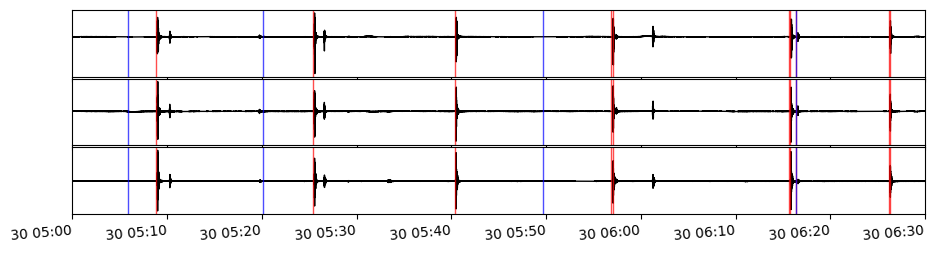

In [50]:
fig,axs = plt.subplots(3,1,figsize=(11,3),sharex=True,gridspec_kw={"hspace":0.03})

tmin = pd.to_datetime("2012-07-30 05:00:00")
tmax = pd.to_datetime("2012-07-30 06:30:00")


axs[0].margins(x=0.01)
for idx,tr in enumerate(la01):
    trc = tr.copy()
    trc = trc.slice(starttime=UTCDateTime(tmin),endtime=UTCDateTime(tmax))
    axs[idx].plot(trc.times("matplotlib"),trc.data,c="k",lw=1)
    axs[idx].set_yticks([])

for ax in axs:
    ax.set_xlim(tmin, tmax)

    # only plot picks within this range
    p_mask = (df_p["Time"] >= tmin) & (df_p["Time"] <= tmax)
    for t in df_p.loc[p_mask, "Time"]:
        ax.axvline(t, color="r", ls="-", lw=1, alpha=0.7)
    s_mask = (df_s["Time"] >= tmin) & (df_s["Time"] <= tmax)
    for t in df_s.loc[s_mask, "Time"]:
        ax.axvline(t, color="b", ls="-", lw=1, alpha=0.7)

fig.autofmt_xdate(rotation=5)
plt.show()